<a href="https://colab.research.google.com/github/protozeit/music-genre-classification/blob/master/exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! curl -O https://os.unil.cloud.switch.ch/fma/fma_metadata.zip && unzip fma_metadata.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  341M  100  341M    0     0  17.1M      0  0:00:19  0:00:19 --:--:-- 26.0M
Archive:  fma_metadata.zip
 bunzipping: fma_metadata/README.txt  
 bunzipping: fma_metadata/checksums  
 bunzipping: fma_metadata/not_found.pickle  
 bunzipping: fma_metadata/raw_genres.csv  
 bunzipping: fma_metadata/raw_albums.csv  
 bunzipping: fma_metadata/raw_artists.csv  
 bunzipping: fma_metadata/raw_tracks.csv  
 bunzipping: fma_metadata/tracks.csv  
 bunzipping: fma_metadata/genres.csv  
 bunzipping: fma_metadata/raw_echonest.csv  
 bunzipping: fma_metadata/echonest.csv  
 bunzipping: fma_metadata/features.csv  


In [3]:
! curl -O https://raw.githubusercontent.com/protozeit/music-genre-classification/master/utils.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11659  100 11659    0     0  70234      0 --:--:-- --:--:-- --:--:-- 70234


In [5]:
%matplotlib inline

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display

import utils

plt.rcParams['figure.figsize'] = (17, 5)

# Load metadata and features.
tracks = utils.load('fma_metadata/tracks.csv')
genres = utils.load('fma_metadata/genres.csv')
features = utils.load('fma_metadata/features.csv')
echonest = utils.load('fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [6]:
genre_dict = {
    'Hip-Hop': 0,
    'Pop': 1,
    'Folk': 2,
    'Rock': 3,
    'Experimental': 4,
    'International': 5,
    'Electronic': 6,
    'Instrumental': 7,
}

inv_genre_dict = {v: k for k, v in genre_dict.items()}

genre_names = [inv_genre_dict[i] for i in range(8)]

((8000, 207), (8000,))

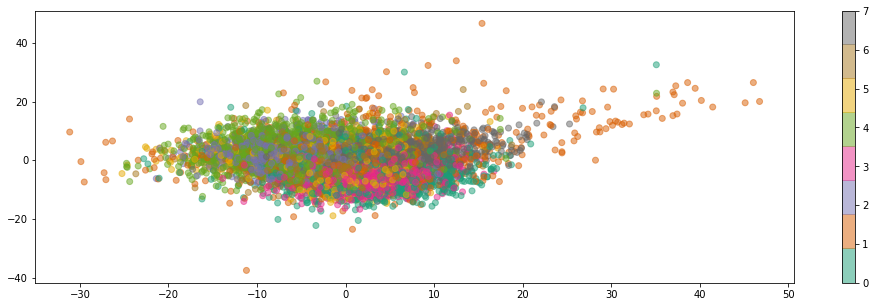

In [7]:
import pickle

genre1 = tracks['track', 'genre_top'] == 'Rock'
genre2 = tracks['track', 'genre_top'] == 'Electronic'

small = tracks['set', 'subset'] <= 'small'

train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'


X = features.loc[small]

X = skl.preprocessing.StandardScaler().fit_transform(X)
pca = skl.decomposition.PCA(.95).fit(X)
X = pca.transform(X)

pickle.dump(pca, open('pca','wb'))

y = tracks.loc[small, ('track', 'genre_top')]
y = skl.preprocessing.LabelEncoder().fit_transform(y)

plt.scatter(X[:,0], X[:,1], c=y, cmap='Dark2', alpha=0.5)
plt.colorbar()
X.shape, y.shape

In [8]:
train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

y_train = tracks.loc[small & train, ('track', 'genre_top')]
y_test = tracks.loc[small & test, ('track', 'genre_top')]
y_val = tracks.loc[small & val, ('track', 'genre_top')]
X_train = features.loc[small & train]
X_test = features.loc[small & test]
X_val = features.loc[small & val]

print(y_train)
print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))

track_id
2         Hip-Hop
5         Hip-Hop
10            Pop
140          Folk
141          Folk
           ...   
153955        Pop
153956        Pop
154413        Pop
154414        Pop
155066    Hip-Hop
Name: (track, genre_top), Length: 6400, dtype: category
Categories (16, object): [Blues, Classical, Country, Easy Listening, ..., Pop, Rock, Soul-RnB, Spoken]
6400 training examples, 800 testing examples
518 features, 8 classes


In [5]:
# Be sure training samples are shuffled.
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=34)

# Standardize features by removing the mean and scaling to unit variance.
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)

array([[ 0.1253238 ,  0.59807614, -0.10177305, ..., -0.10643952,
        -0.8105098 , -0.84468934],
       [-0.34768999, -0.35213792, -0.0645586 , ..., -0.51699423,
        -0.23005883,  1.11347606],
       [-0.0231874 , -0.03538058, -0.03524516, ..., -0.51699423,
         0.08205794,  0.54353052],
       ...,
       [-0.47744417, -0.39346363, -0.15097715, ..., -0.31171687,
         0.04967999,  2.57694115],
       [-0.52918994, -0.47181669, -0.1345473 , ..., -0.10643952,
         1.22919953,  1.71213092],
       [-0.46718922, -0.3620704 , -0.06173892, ...,  1.33050197,
        -0.01398353,  3.47595249]])

In [6]:
from sklearn.metrics import confusion_matrix
import itertools

def train_model(model):
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    print('Accuracy: {:.2%}'.format(score))
    
def draw_cm(model, filename):
    y_predict = model.predict(X_test)
    cm = confusion_matrix(y_test, y_predict)
    print(cm)
    
    df_cm = pd.DataFrame(cm, index = [i for i in genre_names],
                      columns = [i for i in genre_names])
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111)
    cax = ax.matshow(df_cm, cmap='hot')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(8))
    ax.set_yticks(np.arange(8))
    ax.set_xticklabels(genre_names)
    ax.set_yticklabels(genre_names)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "white")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename)
    plt.show()

Accuracy: 47.88%
[[60  9  0  9  6  3  6  7]
 [ 9 43 10  1 18  2  8  9]
 [ 0 23 25  0 11 12 16 13]
 [13  4  0 72  3  5  1  2]
 [ 2 24 26  1 38  1  5  3]
 [ 5  3 28  6  3 41 11  3]
 [14  3  9 13  6  7 41  7]
 [ 0 12  3  4  8  0 10 63]]


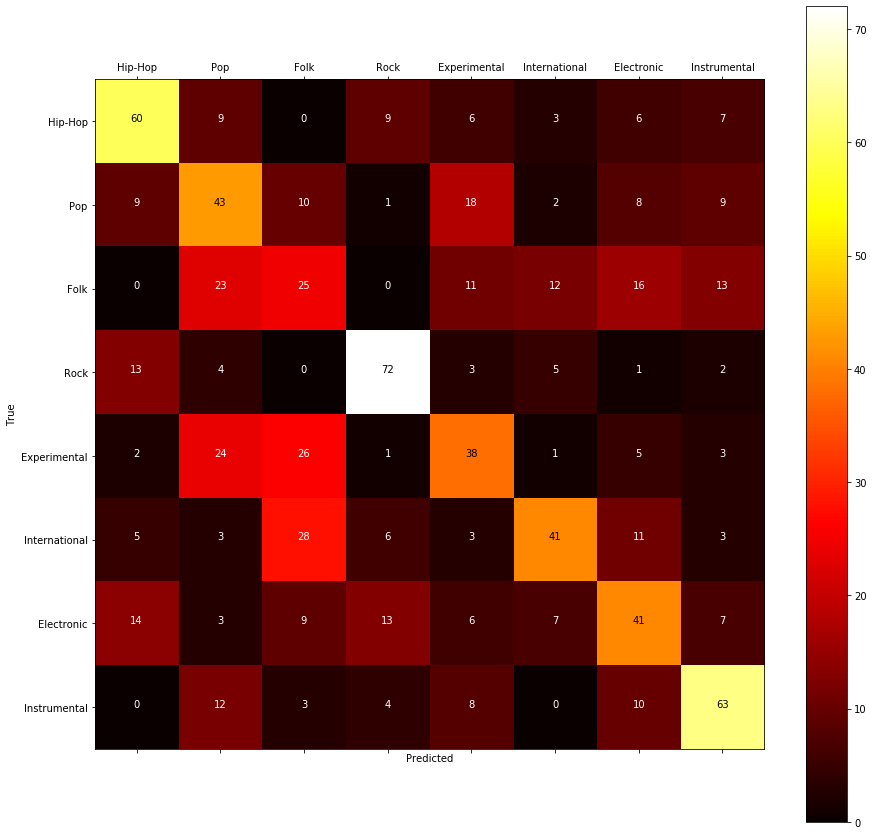

In [168]:
# Support vector classification.
svc = skl.svm.SVC()
train_model(svc)
draw_cm(svc,'baseline_scv_cm.png')

Accuracy: 40.00%
[[45 21  0  9  5  4  7  9]
 [10 32 14  2 14  8 11  9]
 [ 2 28 31  1  5 10 21  2]
 [ 9  8  2 63  0 10  1  7]
 [ 3 12 31  2 36  2 11  3]
 [ 6  6 26  4  6 37 12  3]
 [17 12  4 10  7  9 25 16]
 [ 4 15  7  2  1  5 15 51]]


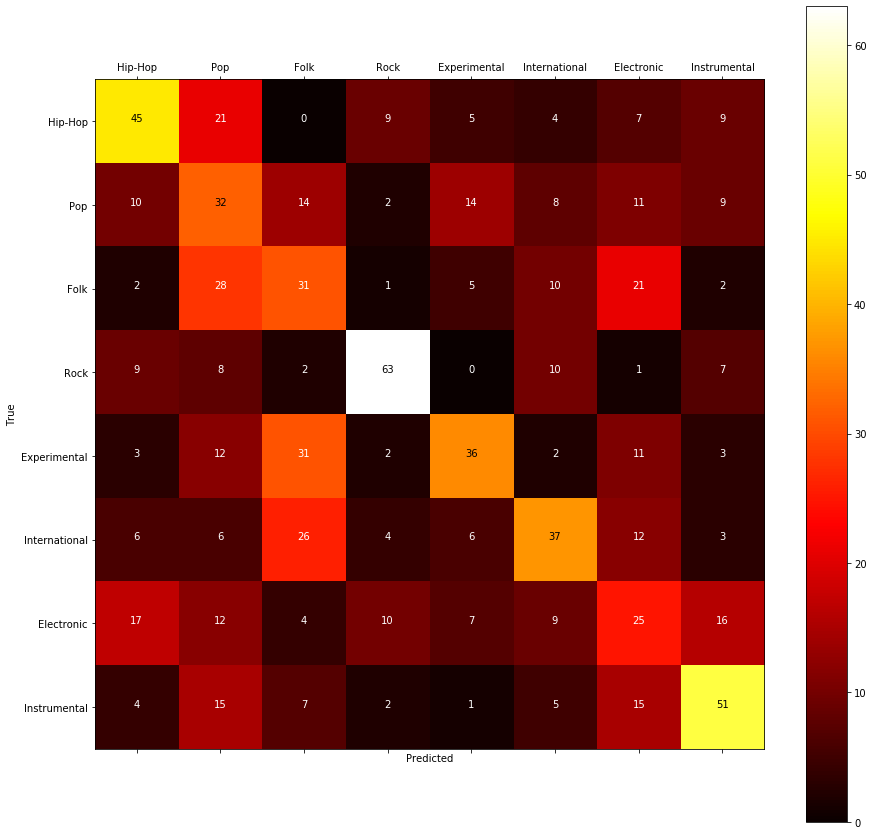

In [0]:
# Perceptron classification.
per = skl.linear_model.Perceptron(tol=1e-9, random_state=532)
train_model(per)
draw_cm(per,'baseline_perceptron_cm.png')

Accuracy: 39.62%
[[45  2  0 26  7  4 11  5]
 [16 14 21  2 15 10  7 15]
 [ 0 26 28  0 15 10  6 15]
 [15  3  1 63  2  4  0 12]
 [ 1  9 47  1 33  3  2  4]
 [ 8  4 32  9  0 31  9  7]
 [15  5  7 11 12 16 30  4]
 [ 1  7  2  1  6  2  8 73]]


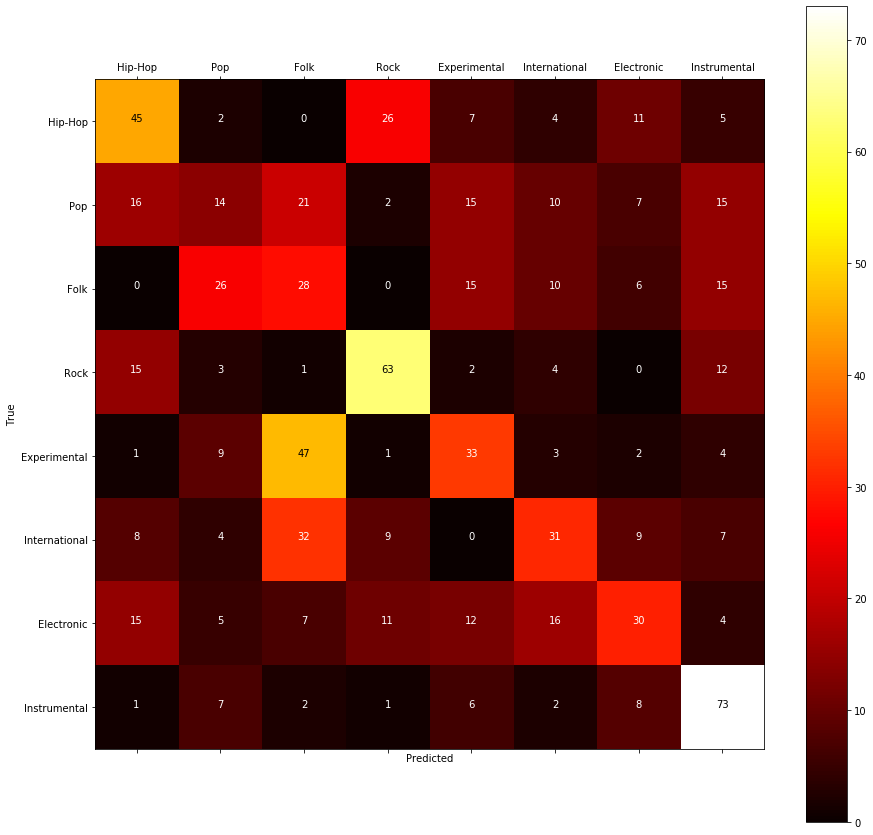

In [0]:
# Nearest centroid classification.
nei = skl.neighbors.NearestCentroid()
train_model(nei)
draw_cm(nei,'baseline_nearest_centroid_cm.png')

Accuracy: 29.25%
[[35 16  5 15  9  9  6  5]
 [ 9 22 12  9 16  7 12 13]
 [ 7 18 16  4 18 11 10 16]
 [14  7  2 38  1 17 12  9]
 [ 5 17 19  4 30  8 10  7]
 [ 9 19 11  6  2 37 10  6]
 [17  9 17  8  5 16 21  7]
 [ 5  9  7  9 15  3 17 35]]


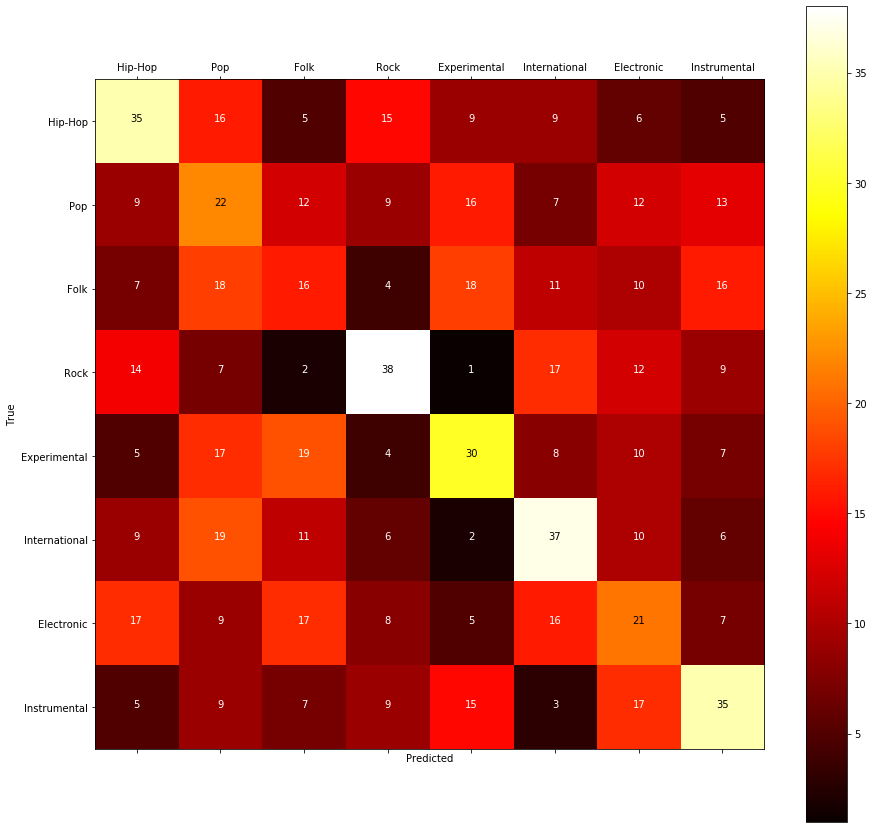

In [0]:
# Decision tree classification.
dtc = skl.tree.DecisionTreeClassifier()
train_model(dtc)
draw_cm(dtc,'baseline_decision_tree_cm.png')

Accuracy: 43.25%
[[48 10  2  8  6  3 13 10]
 [ 8 38  9  1 14  4 13 13]
 [ 0 29 28  0  5  8 19 11]
 [11  4  2 63  1  3 12  4]
 [ 4 11 21  1 45  2 14  2]
 [ 3  9 19  4  2 46 16  1]
 [13 11 15  6  9  4 35  7]
 [ 4 13  8  2  9  4 17 43]]


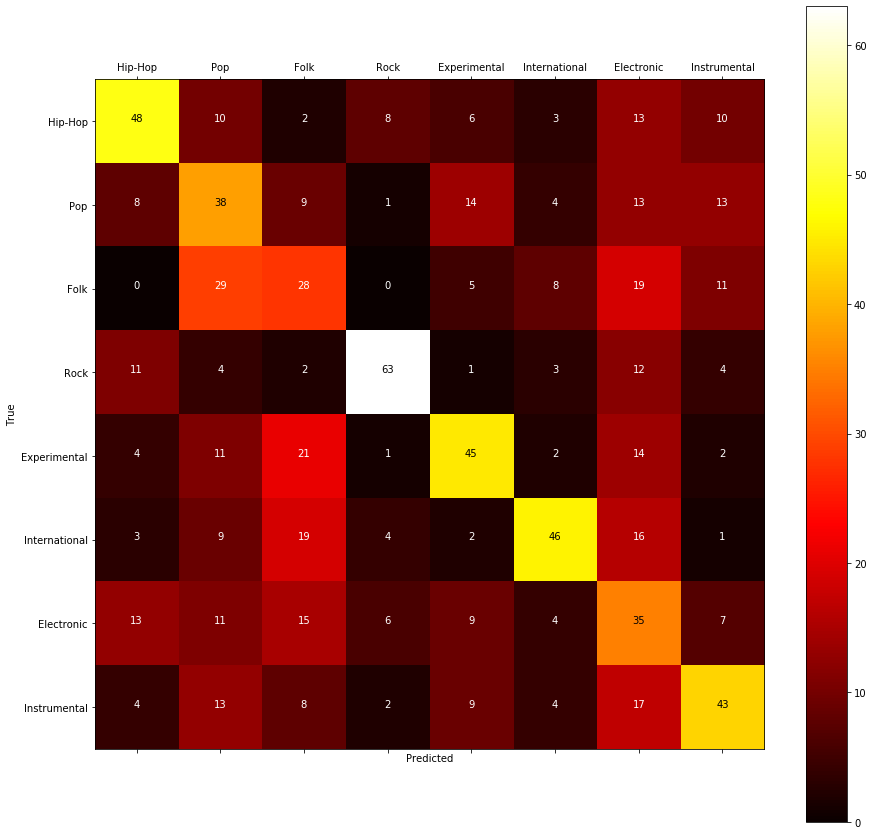

In [0]:
# NN classification.
from sklearn.neural_network import MLPClassifier                                       
mlp_1 = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=1000,
                   hidden_layer_sizes=(256, 128, 64, 8), random_state=532)
train_model(mlp_1)
draw_cm(mlp_1,'baseline_mlp_lbfgs_cm.png')

Accuracy: 41.38%
[[53  7  0 13  8  2  9  8]
 [12 45 10  2 13  2 12  4]
 [ 4 38 13  0  9 16 12  8]
 [16  2  1 67  2  4  8  0]
 [ 6 19 23  0 35  3 10  4]
 [ 6 10 16  3  4 49 10  2]
 [19 11 10  7  6 10 32  5]
 [ 5 13 11  1  5  4 24 37]]


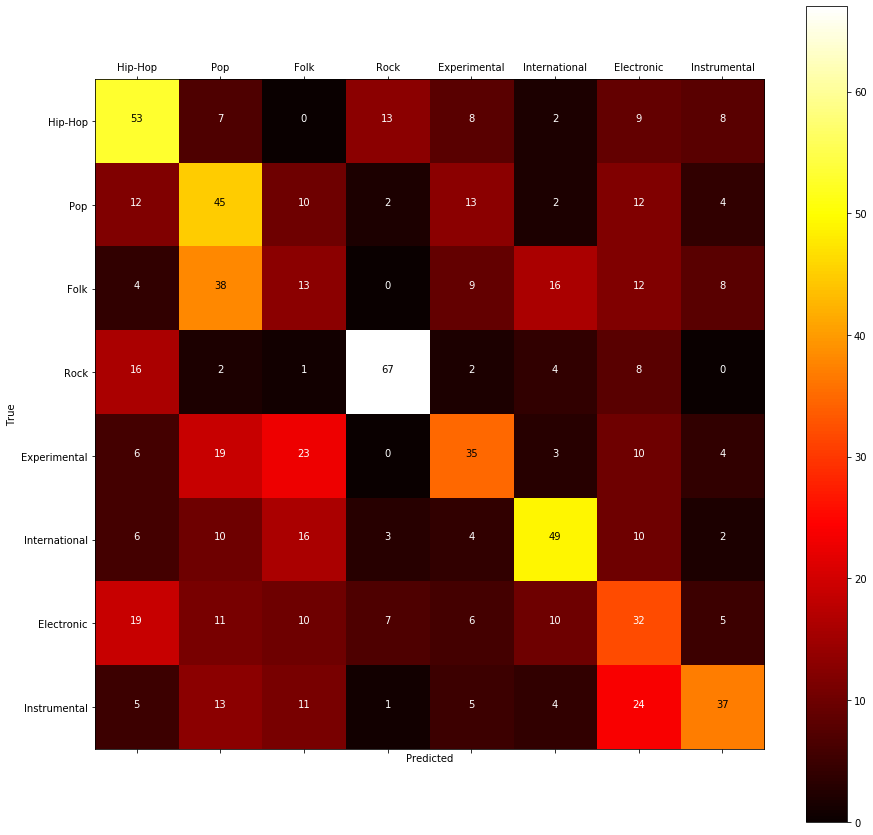

In [0]:
mlp_2 = MLPClassifier(solver='adam', alpha=1e-5, max_iter=1000, activation='relu',
                   hidden_layer_sizes=(256, 128, 64, 8), random_state=532)
train_model(mlp_2)
draw_cm(mlp_2,'baseline_mlp_adam_cm.png')

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D
from keras.utils import np_utils
from tensorflow.keras.optimizers import RMSprop, Nadam

import keras

X_train, X_test_val, y_train, y_test_val = skl.model_selection.train_test_split(X, y, test_size=0.2)

X_test, X_val = np.split(X_test_val, 2)
y_test, y_val = np.split(y_test_val, 2)

print(X_train.shape, X_test.shape, y_train.shape, y_val.shape)
print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))

(6400, 207) (800, 207) (6400,) (800,)
6400 training examples, 800 testing examples
207 features, 8 classes


Using TensorFlow backend.


In [373]:
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))

model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(8, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_319 (Dense)            (None, 128)               26624     
_________________________________________________________________
dropout_213 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_320 (Dense)            (None, 32)                4128      
_________________________________________________________________
dropout_214 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_321 (Dense)            (None, 8)                 264       
Total params: 31,016
Trainable params: 31,016
Non-trainable params: 0
_________________________________________________________________


In [11]:
epochs = 40
batch_size = 64

Train on 6400 samples, validate on 800 samples
Epoch 1/100
6400/6400 [==============================] - 4s 610us/sample - loss: 2.3150 - acc: 0.2022 - val_loss: 1.8061 - val_acc: 0.3775
Epoch 2/100
6400/6400 [==============================] - 1s 120us/sample - loss: 1.8083 - acc: 0.3500 - val_loss: 1.5725 - val_acc: 0.4812
Epoch 3/100
6400/6400 [==============================] - 1s 124us/sample - loss: 1.6029 - acc: 0.4198 - val_loss: 1.4287 - val_acc: 0.5138
Epoch 4/100
6400/6400 [==============================] - 1s 118us/sample - loss: 1.5134 - acc: 0.4661 - val_loss: 1.3633 - val_acc: 0.5362
Epoch 5/100
6400/6400 [==============================] - 1s 121us/sample - loss: 1.4185 - acc: 0.5017 - val_loss: 1.3031 - val_acc: 0.5487
Epoch 6/100
6400/6400 [==============================] - 1s 114us/sample - loss: 1.3568 - acc: 0.5136 - val_loss: 1.2733 - val_acc: 0.5550
Epoch 7/100
6400/6400 [==============================] - 1s 114us/sample - loss: 1.2876 - acc: 0.5412 - val_loss: 1.248

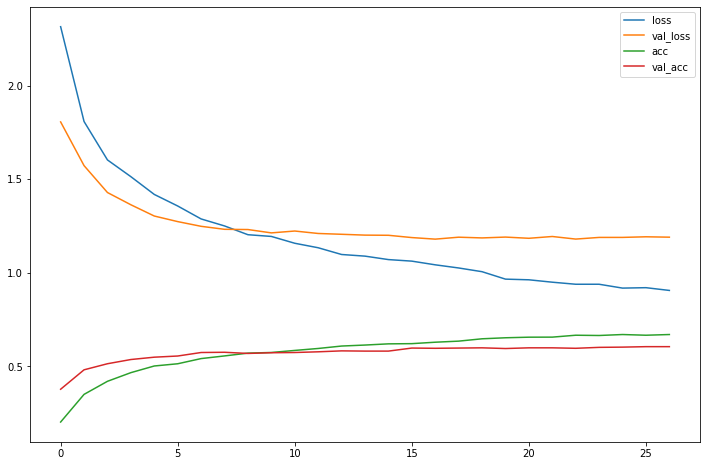

800/800 [==============================] - 0s 124us/sample - loss: 1.1080 - acc: 0.6212
Test loss: 1.108019790649414
Test accuracy: 0.62125


In [374]:
tb_hist = keras.callbacks.TensorBoard(log_dir='.', histogram_freq=0, write_graph=True, write_images=True)

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
hist = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, validation_data= (X_val, y_val), callbacks=[es_callback]) 

plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['loss','val_loss', 'acc','val_acc'])
plt.show()

score = model.evaluate(x=X_test, y=y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [0]:
model.save('asdf.h5')

In [12]:
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))

model.add(Dropout(0.6))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               26624     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 2056      
Total params: 61,704
Trainable params: 61,704
Non-trainable params: 0
_________________________________________________________________


Train on 6400 samples, validate on 800 samples
Epoch 1/40
6400/6400 [==============================] - 1s 116us/sample - loss: 2.2977 - accuracy: 0.2377 - val_loss: 1.6384 - val_accuracy: 0.4462
Epoch 2/40
6400/6400 [==============================] - 0s 50us/sample - loss: 1.8035 - accuracy: 0.3566 - val_loss: 1.5420 - val_accuracy: 0.5175
Epoch 3/40
6400/6400 [==============================] - 0s 50us/sample - loss: 1.6543 - accuracy: 0.3966 - val_loss: 1.4738 - val_accuracy: 0.5312
Epoch 4/40
6400/6400 [==============================] - 0s 49us/sample - loss: 1.5489 - accuracy: 0.4470 - val_loss: 1.4216 - val_accuracy: 0.5487
Epoch 5/40
6400/6400 [==============================] - 0s 50us/sample - loss: 1.4762 - accuracy: 0.4700 - val_loss: 1.3776 - val_accuracy: 0.5675
Epoch 6/40
6400/6400 [==============================] - 0s 52us/sample - loss: 1.4240 - accuracy: 0.4872 - val_loss: 1.3465 - val_accuracy: 0.5825
Epoch 7/40
6400/6400 [==============================] - 0s 50us/sample

KeyError: 'acc'

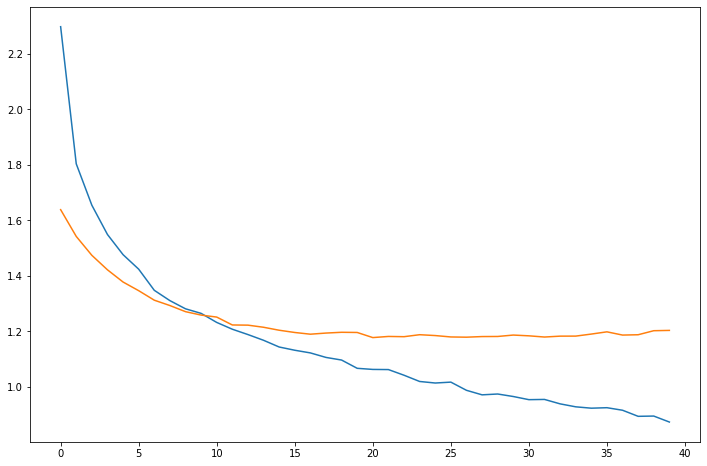

In [13]:
tb_hist = keras.callbacks.TensorBoard(log_dir='.', histogram_freq=0, write_graph=True, write_images=True)

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
hist = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, validation_data= (X_val, y_val), ) 

plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['loss','val_loss', 'acc','val_acc'])
plt.show()

score = model.evaluate(x=X_test, y=y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [0]:
model.save('DNN2.h5')

In [19]:
model.load_weights("model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               26624     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 2056      
Total params: 61,704
Trainable params: 61,704
Non-trainable params: 0
_________________________________________________________________


[[56  1  1  7 10  1 15  3]
 [ 8 44  4  4 14  5 13 11]
 [ 0  6 70  0  5  7 16  5]
 [12  1  1 51  4  2  6  2]
 [ 4  7 12  1 63  3  7  6]
 [ 7  2  5  6  3 72 10  5]
 [ 7  3 13  5  2  6 43 19]
 [ 4  9  7  4  0  2 11 67]]


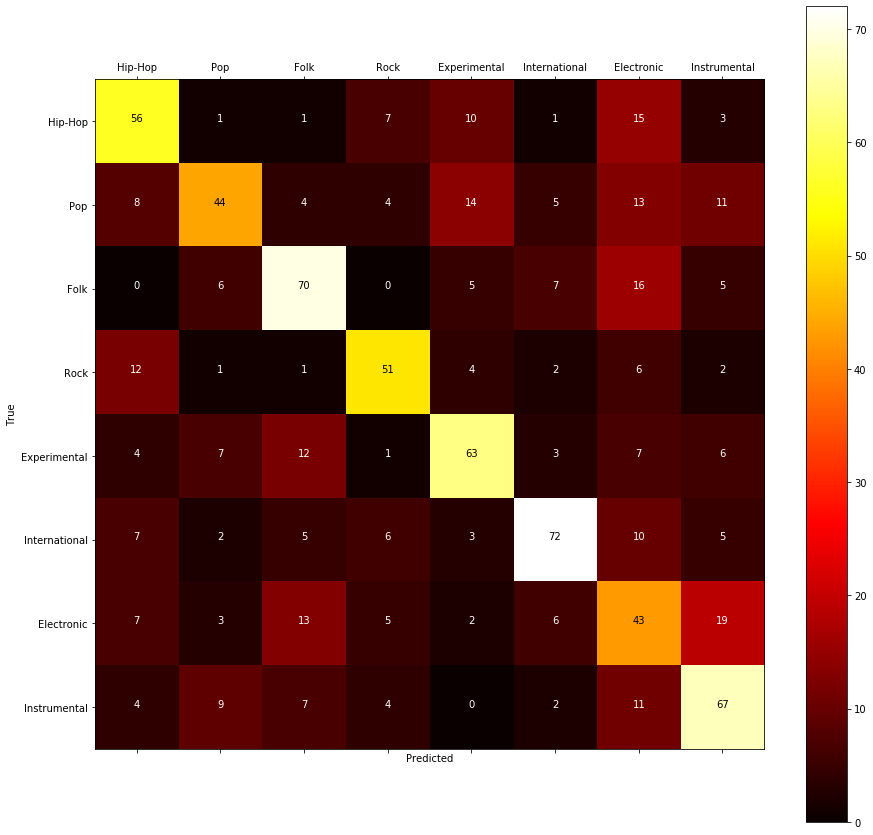

In [20]:
def draw_cm(model, filename):
    y_predict = model.predict_classes(X_test)
    cm = confusion_matrix(y_test, y_predict)
    print(cm)
    
    df_cm = pd.DataFrame(cm, index = [i for i in genre_names],
                      columns = [i for i in genre_names])
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111)
    cax = ax.matshow(df_cm, cmap='hot')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(8))
    ax.set_yticks(np.arange(8))
    ax.set_xticklabels(genre_names)
    ax.set_yticklabels(genre_names)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "white")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename)
    plt.show()

draw_cm(model, 'DNN_cm.png')

In [388]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
